# 和CLIP交互

这是一个独立完整的笔记本，展示了如何下载并运行 CLIP 模型、计算任意图像与文本输入之间的相似度，以及执行零样本图像分类任务。

# Colab 环境准备

请确保当前运行的是 GPU 运行时环境；若未启用，可通过菜单栏依次点击「Runtime（运行时）> Change Runtime Type（更改运行时类型）」，将硬件加速器设置为「GPU」。后续单元格将安装`clip`包及其依赖项，并检查是否已安装 PyTorch 1.7.1 或更高版本。

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/z6/dz0yb7c95n9dtykytfy42j0r0000gn/T/pip-req-build-hvnp51xs
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/z6/dz0yb7c95n9dtykytfy42j0r0000gn/T/pip-req-build-hvnp51xs
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=b7d4a258b5f5681764c48caad1d6fb5f2940ec3d073b37143ba6f7d801213ef5
  Stored in directory: /private/var/folders/z6/dz0yb7c95n9dtykytfy42j0r0000gn/T/pip-ephem-wheel-cache-25smur4a/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.9.1


# 加载模型

`clip.available_models()`会列出所有可用的CLIP模型。

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
model, preprocess = clip.load("ViT-B/32")
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device).eval()  # model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# 图像预处理
我们会先调整输入图像的尺寸，并对其进行中心裁剪，以匹配模型所需的图像分辨率。在此之前，我们将利用数据集的均值和标准差对像素亮度进行归一化处理。`clip.load()`函数返回的第二个值是一个 torchvision 库中的`Transform`类实例，该实例可完成上述预处理操作。



In [8]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x16128add0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# 文本预处理

我们使用一个大小写不敏感的分词器，可通过`clip.tokenize()`函数调用该分词器。默认情况下，输出结果会被填充至 77 个标记（token）的长度 —— 这正是 CLIP 模型所需的输入长度。

In [9]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# 输入图像与文本的准备工作

我们将向模型输入 8 张示例图像及其文本描述，并对比对应特征之间的相似度。

该分词器对大小写不敏感，因此我们可以灵活给出任意合适的文本描述。

In [12]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# skimage中的图像及其文本描述
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

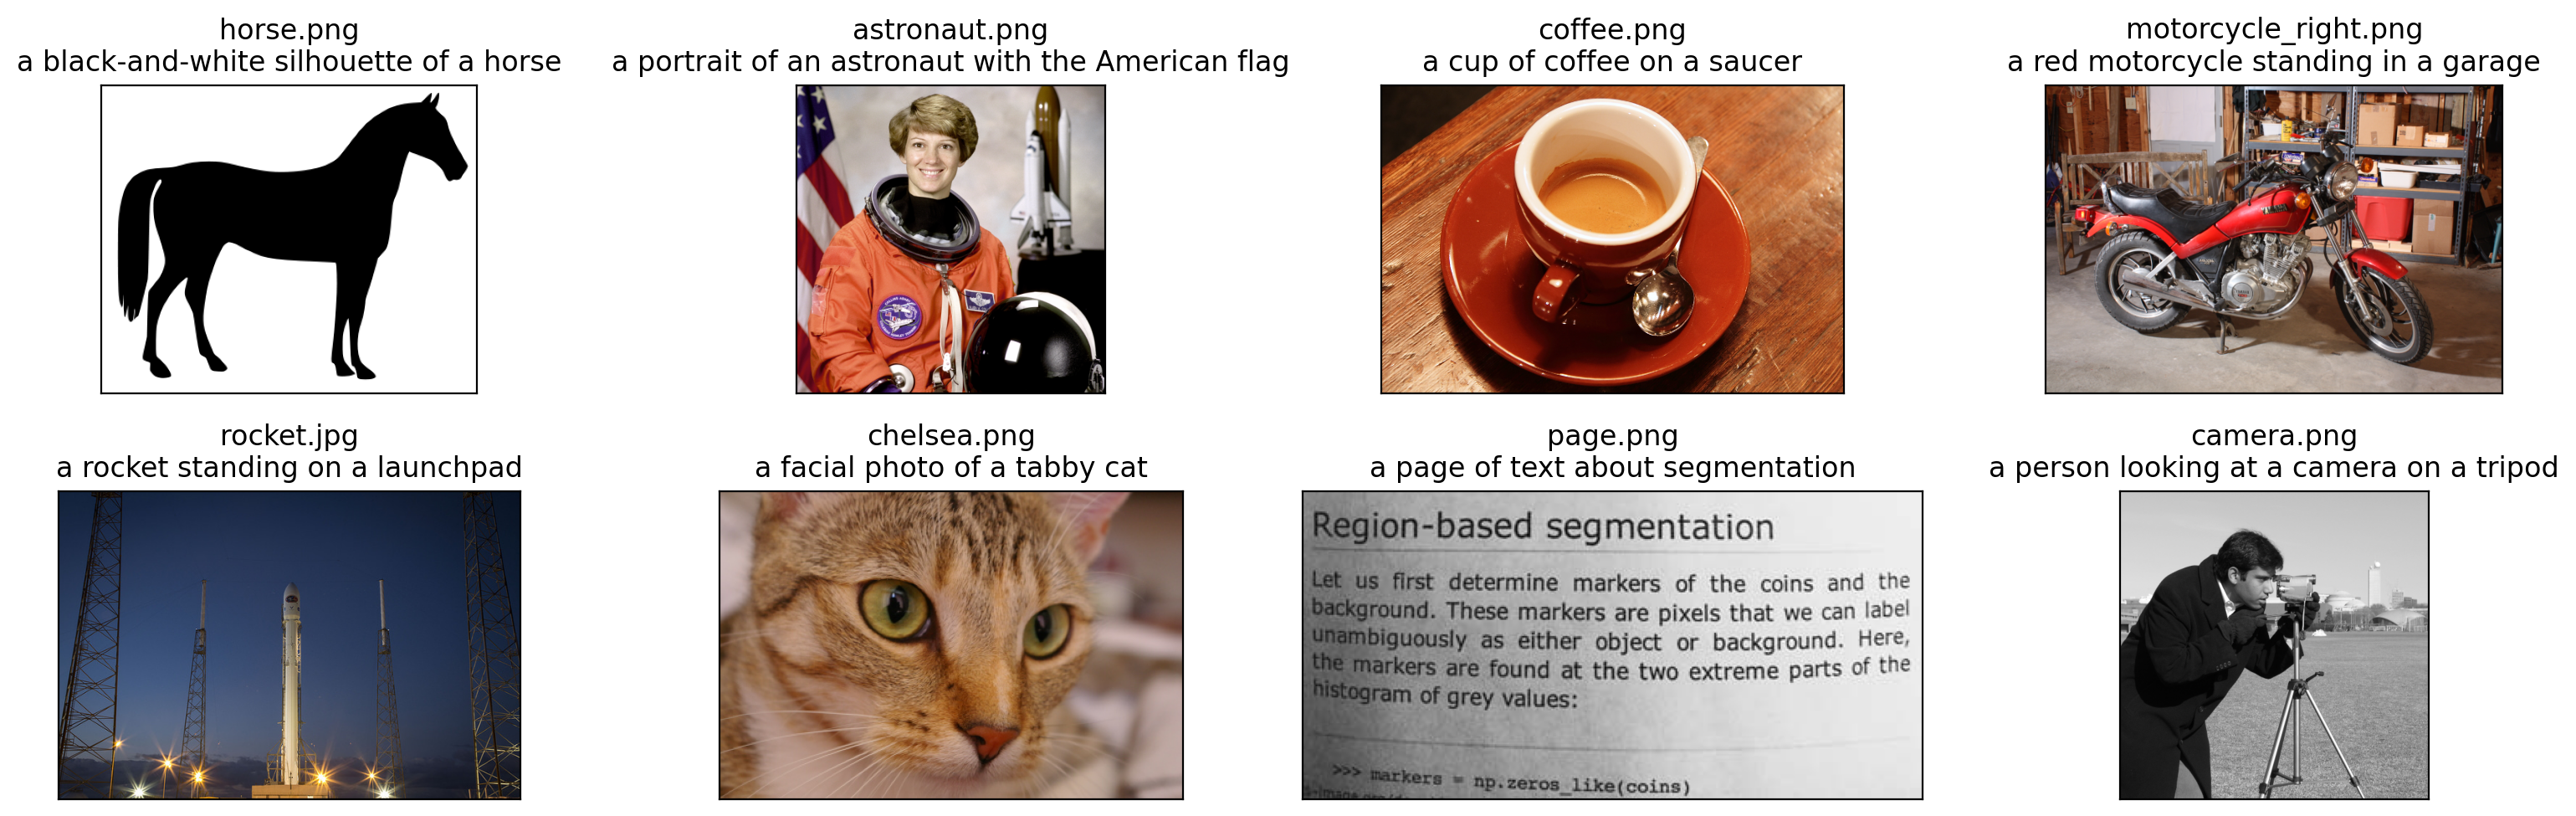

In [13]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## 特征构建

我们先对图像进行归一化处理，对每个文本输入执行分词操作，再通过模型的前向传播（forward pass）得到图像特征与文本特征。

In [15]:
image_input = torch.tensor(np.stack(images)).to(device)  # torch.Size([8, 3, 224, 224])
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)  # torch.Size([8, 77])

In [16]:
with torch.no_grad():  # 输出均为torch.Size([8, 512])
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## 余弦相似度计算

我们先对特征进行归一化处理，再计算每对特征之间的点积（dot product）。

In [26]:
image_features /= image_features.norm(dim=-1, keepdim=True)  # torch.Size([8, 512])
text_features /= text_features.norm(dim=-1, keepdim=True)  # torch.Size([8, 512])
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T  # torch.Size([8, 8])

Text(0.5, 1.0, 'Cosine similarity between text and image features')

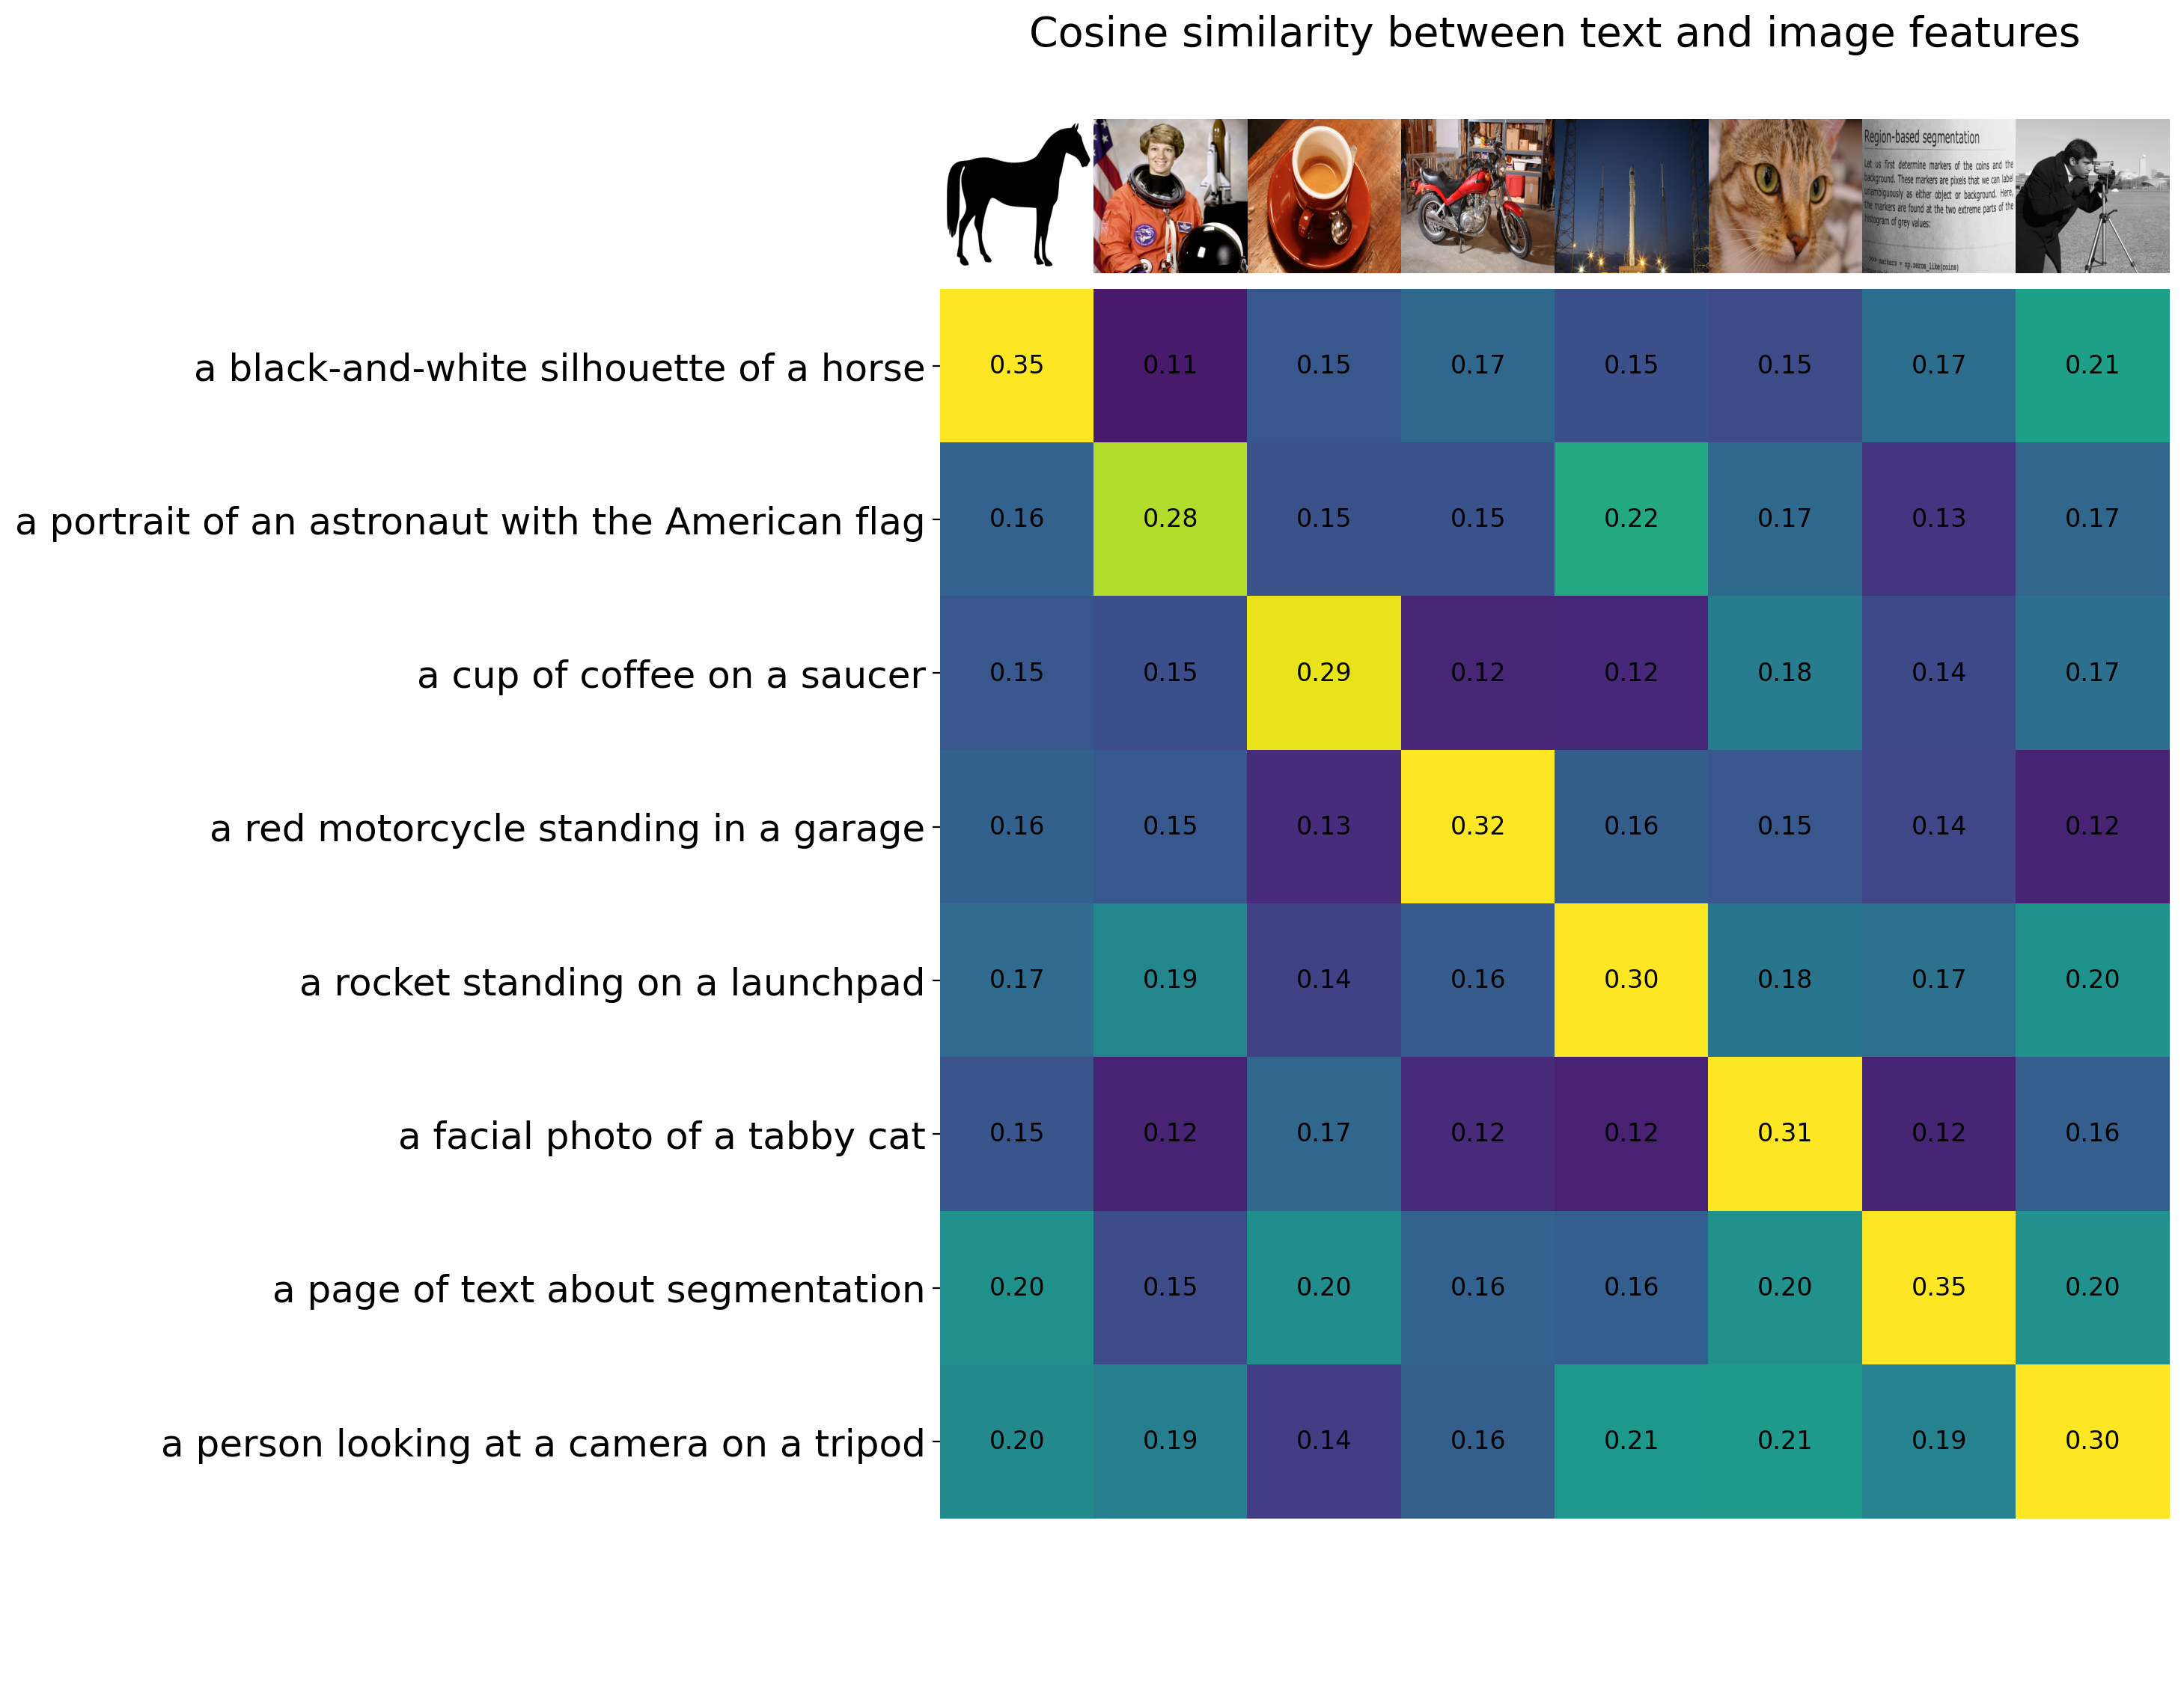

In [27]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# 零样本图像分类

你可以将余弦相似度（乘以 100）作为输入到 softmax 操作的对数几率（logits），以此完成图像分类。

In [28]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169M/169M [00:18<00:00, 8.95MB/s] 


In [30]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

In [31]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

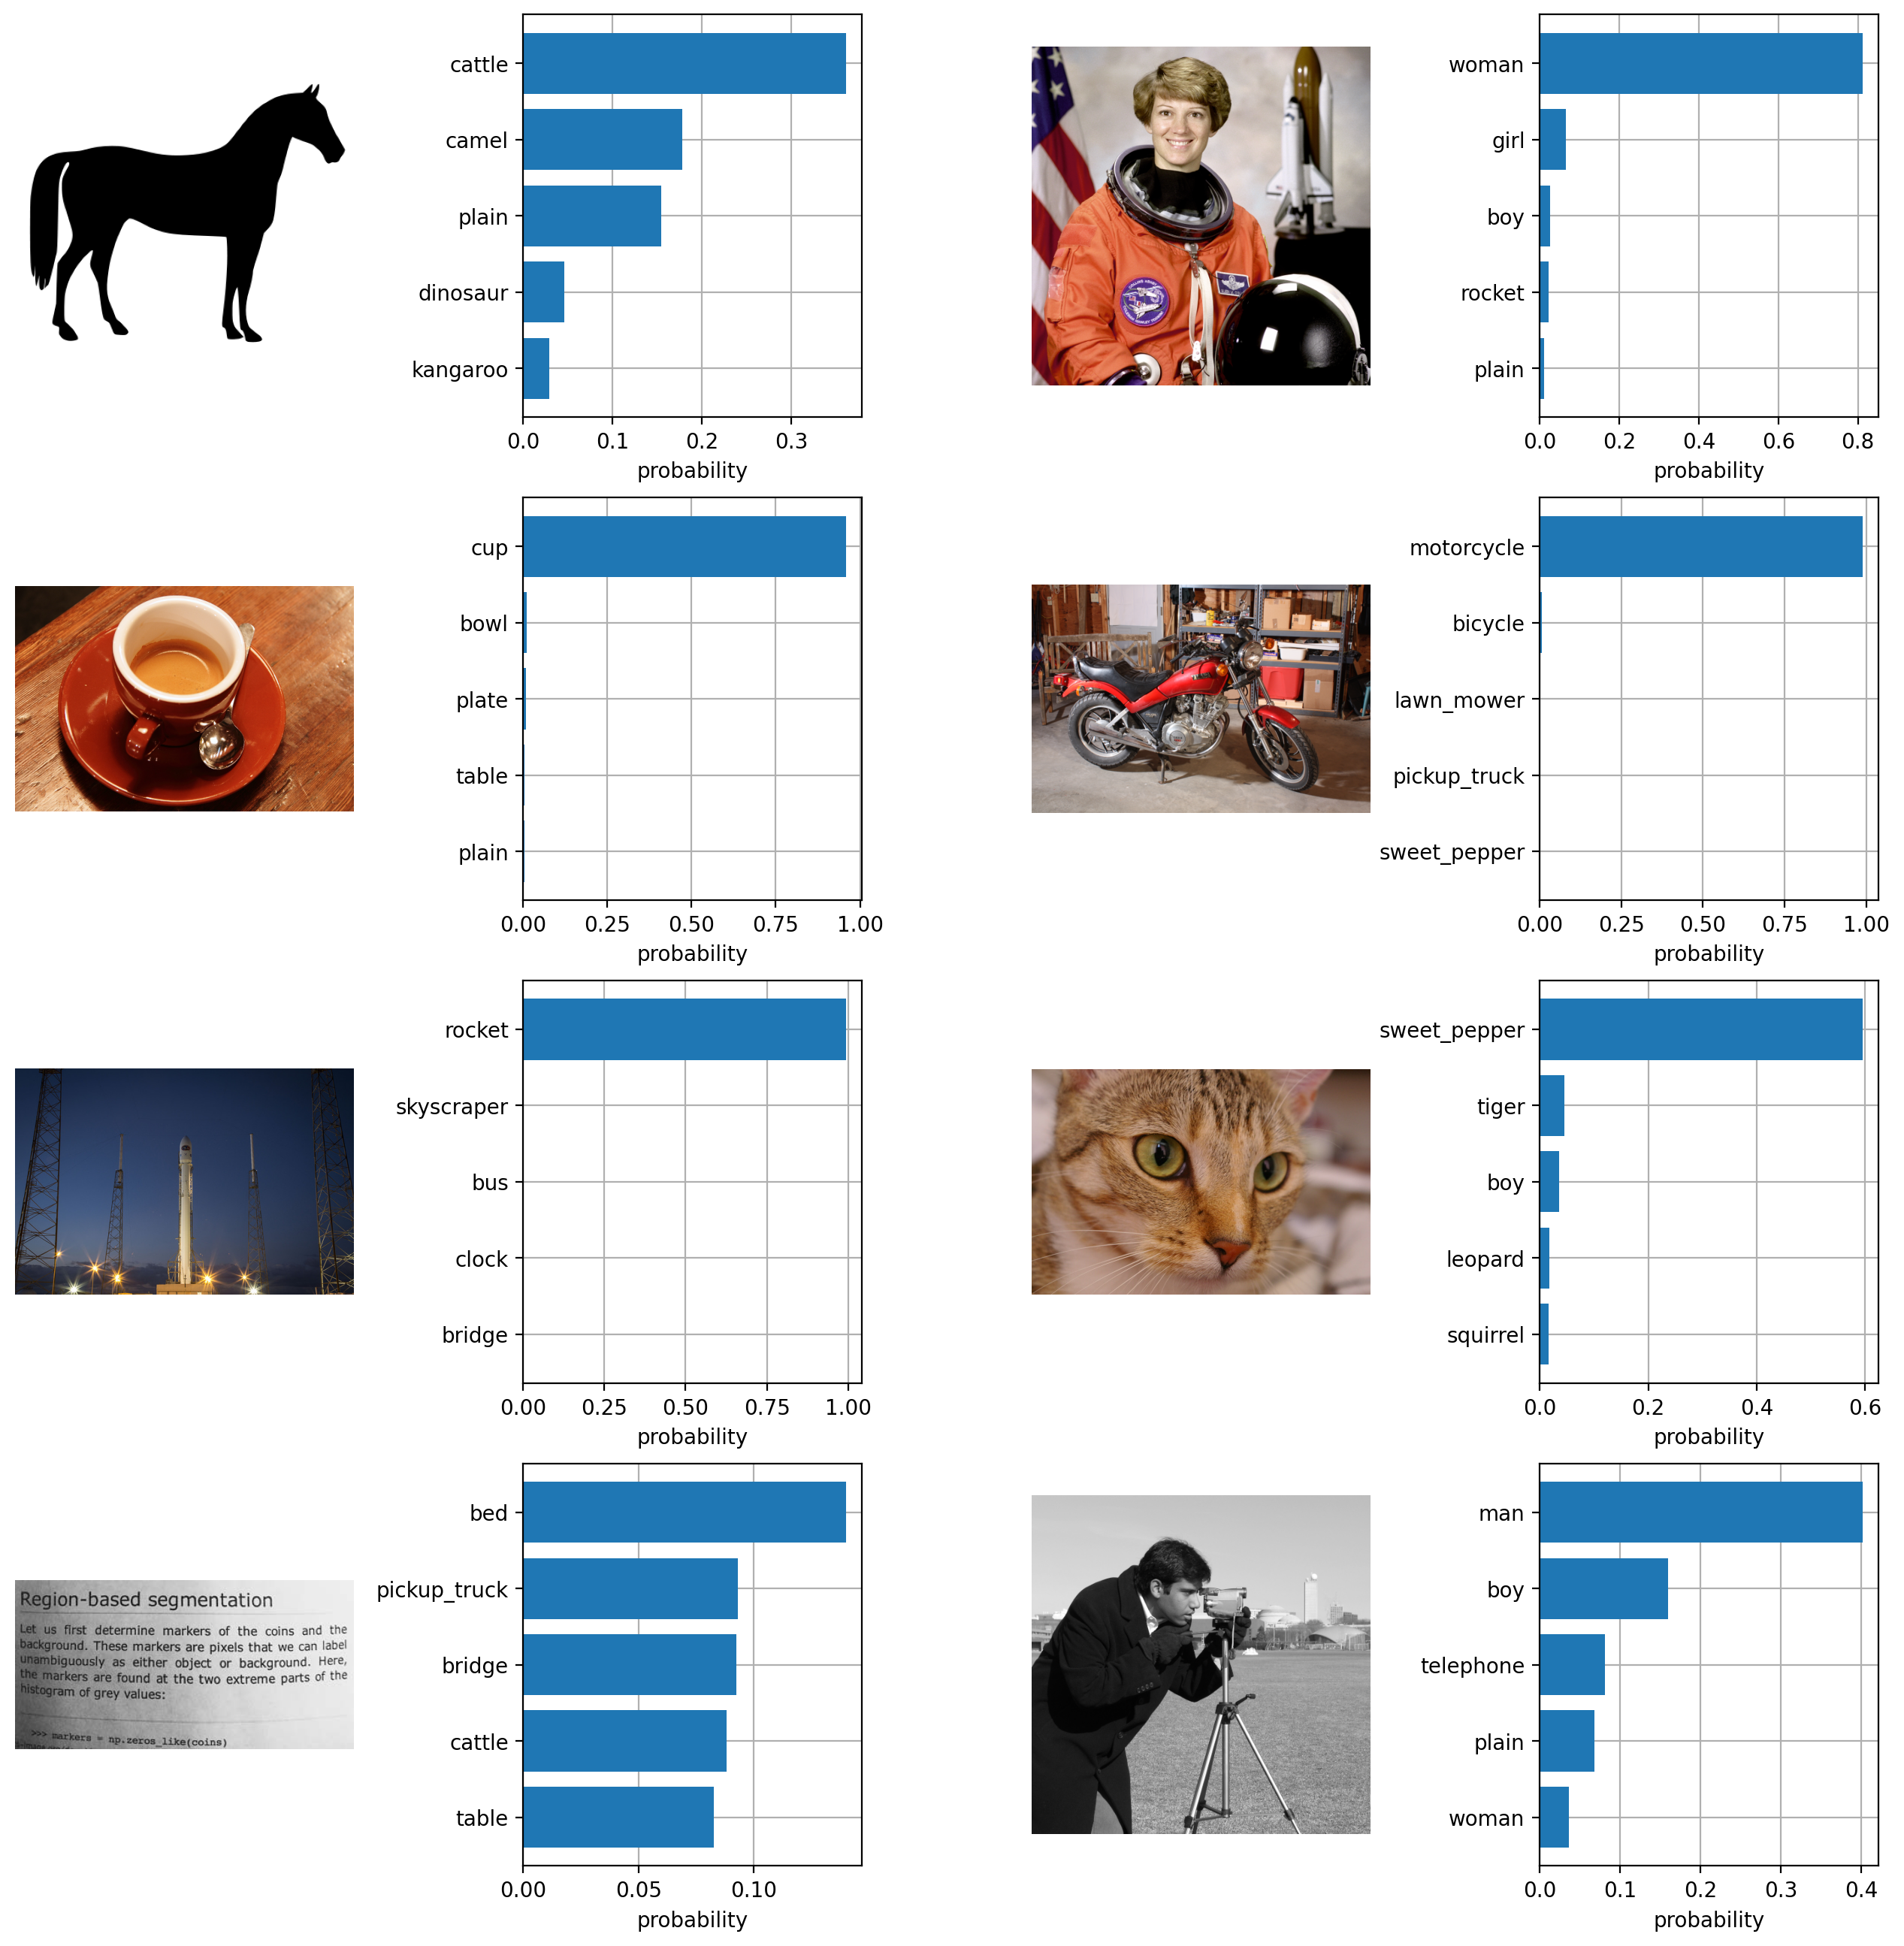

In [32]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()